# CSCA 5632 - Unsupervised Learning Final Project
This is Diego Marquez's submission for the Unuspervised Learning course's Final Project

## Project Topic
This project is an attempt at the [Personalized Medicine: Redefining Cancer Treatment](https://www.kaggle.com/competitions/msk-redefining-cancer-treatment/overview) Kaggle Competition.
The competition consists of classifying a few entries containing gene, gene variation and a scientific text describing the observed phenomenon into a set of 9 cancer classes.
I devised my own approach without looking at previous submissions for the sake of research and learning.

### Motivation
My motivation was to explore applications of dimensionality reduction techniques and observing how clustering algorithms could perform for this kind of project.
As you'll see, I found some new technique for vectorizing the text dataset that gave me a decent accuracy for the final predictions when combining unsupervised and supervised learning algorithms.

The main objective is to **leverage unsupervised learning methods in order to produce an input matrix we can easily derive classes from with aid of other supervised learning algorithms**.

### Scope
Unsupervised learning algorithms are the main method of dimensionality reduction, which are crucial for the last classifier to take proper effect.

## Data
Iker Huerga and Wendy Kan. Personalized Medicine: Redefining Cancer Treatment. https://kaggle.com/competitions/msk-redefining-cancer-treatment, 2017. Kaggle.

This Kaggle competition declares _We need your help to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations._

### Analyzing the Data Structure

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import NMF, PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import nltk
nltk.download('wordnet')
import re
from gensim.models import Word2Vec
from functools import lru_cache
import time

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diegomarquezp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
text_names=['ID', 'Text']
training_text_df = pd.read_csv('training_text', sep='\\|\\|', engine='python', skiprows=1, names=text_names)
training_variants_df = pd.read_csv('training_variants')
test_text_df = pd.read_csv('test_text', sep='\\|\\|', engine='python', skiprows=1, names=text_names)
test_variants_df = pd.read_csv('test_variants')

In [3]:
training_text_df.head()

ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [4]:
training_variants_df.head()

ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [5]:
training_df = pd.merge(training_variants_df, training_text_df, on='ID', suffixes=('', '_'))
test_df = pd.merge(test_variants_df, test_text_df, on='ID', suffixes=('', '_'))

training_df.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                Text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...

In [6]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
 4   Text       3316 non-null   object
dtypes: int64(2), object(3)
memory usage: 129.9+ KB


We can observe the training dataset is **tabulated** with `3321` entries main features: `gene`, `gene variation` and `text`. The first two are a somewhat simple feature we can treat as classes, but Text is where the main classification difficulty comes from. The data presents no major challenges for preprocessing and vectorization.

## Preparing and Cleaning the Data
The main challenge is to convert the `Text` feature into a meaningful matrix that can be easily interpreted by the algorithms I'm familiar with.
It's worth noting that the nature of this challenge is closer to **Natural Language Processing** than **Unsupervised Learning**, but I will later show how we can leverage dimensionality reduction upon the vectorized text feature to maximize the effectiveness of the final classifier.

### Lemmatization
This technique is borrowed from **Natural Language Processing** and consists of reducing a string representing a word to its root. For example "rectification" would be lemmatized to "rect", which is the latin root of "corner". Using this technique, we can then count occurences on a simplified set of words.

For this, we use the `ntlk` package, available at https://www.nltk.org/, which offers several tools for natural language processing.

### TF-IDF
Stands for "Term Frequency" and "Inverse Document Frequency". Essentially, produces a matrix of the importance of each word on a document depending on the frequency it appears in a text entry. The values are normalized via inverse frequency, which produces a value between 0 and 1 to compress the relative frequency across the document.
This can be thought of a bag-of-words with extra steps to make it more interpretable by machine learning algorithms.

### Word2Vec
This is a **Natural Language Processing** technique that converts each words into a vector of an arbitrary number of dimensions. The main deciding factor of the values of the words are the neighbor words. It has interesting properties that can be very helpful for classifier algorithms. For example the word `queen` and `king` may have a vectorial difference that is very similar to the vectorial difference between `woman` and `man`.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Word_vector_illustration.jpg/960px-Word_vector_illustration.jpg" width="200" height="200" />

### Validity of the approach
These techniques are borderline outliers considering the scope of the course, but they were crucial in order to obtain a decent model accuracy. Personally, it's worth trying them again once I have finished the NLP courses.


In [7]:
def create_time_tracker():
    last_time = [time.time()] # Using a mutable list to hold state for nonlocal access
    def tracker(message):
        current_time = time.time()
        delta = current_time - last_time[0]
        print(f"[{message}]: {delta:.4f} seconds")
        last_time[0] = current_time
    return tracker

In [8]:
# Now I'm going to encode the dataframe into a sparse matrix.)
# For Gene and Variation, I will use One-Hot encoding (boolean values 0 or 1)
# I will use TF-IDF vectorization for text, where it gives me continous range [0,1] telling the normalized frequency
# That will give me a sparse matrix only with cell values 0 or 1

print('Ready')
track_time = create_time_tracker()

subset_size = 3321
training_subset = training_df[0:subset_size]
test_subset = test_df[0:subset_size]


lemmatizer = nltk.stem.WordNetLemmatizer()

lemmatize = lru_cache(maxsize=2000000)(lemmatizer.lemmatize)
token_pattern = r"(?u)\b\w\w+\b"


def tokenizer(raw_text): 
    tokens = re.findall(token_pattern, str(raw_text))
    result = [lemmatize(word) for word in tokens]
    return result

def tokenizer_merged(raw_text):
    return ' '.join(tokenizer(raw_text))

track_time('Initialized')
    
np_tokenizer = np.vectorize(tokenizer, otypes=[list]) 
np_tokenizer_merged = np.vectorize(tokenizer_merged, otypes=[str]) 
track_time('Token vectorizer created')

tokenized_training = np_tokenizer(training_subset['Text'].values.astype('U'))
tokenized_test = np_tokenizer(test_subset['Text'].values.astype('U'))
tokenized_merged_training = np_tokenizer_merged(training_subset['Text'].values.astype('U'))
tokenized_merged_test = np_tokenizer_merged(test_subset['Text'].values.astype('U'))

track_time('Tokenization finished')


tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df=3, max_df=0.95, decode_error='ignore')
tfidf_training = tfidf.fit_transform(tokenized_merged_training)
tfidf_test = tfidf.transform(tokenized_merged_test)

track_time('TFIDF finished')




vector_size = 300
word2vec = Word2Vec(sentences=tokenized_training, vector_size=vector_size, window=5, min_count=1, workers=4)

track_time('Word2Vec training finished')

from collections import defaultdict
#vocab = defaultdict(lambda : -1, **tfidf.vocabulary_)

vocab = set(word2vec.wv.index_to_key).intersection(tfidf.vocabulary_.keys())

def get_sentence_vector(x):
    index, word_list = x
    # Filter out words not in the model's vocabulary
    word_vectors = []
    filtered_word_list = set(word_list).intersection(vocab)
    for word in filtered_word_list:
        tfidf_index = tfidf.vocabulary_[word]
        vector = word2vec.wv[word] * tfidf_training[index,tfidf_index]
        word_vectors.append(vector)
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size) # Return a zero vector if no words are found
vectorized_training_map = map(get_sentence_vector, enumerate(tokenized_training))
vectorized_test_map = map(get_sentence_vector, enumerate(tokenized_test))

vectorized_training = np.array(np.fromiter(vectorized_training_map, dtype=np.ndarray).tolist())
vectorized_test = np.array(np.fromiter(vectorized_test_map, dtype=np.ndarray).tolist())
# vectorized_training = tfidf_training
# vectorized_test = tfidf_test

track_time('Vectorization finished')
print(vectorized_training.shape)

Ready
[Initialized]: 0.0010 seconds
[Token vectorizer created]: 0.0000 seconds
[Tokenization finished]: 139.5282 seconds
[TFIDF finished]: 58.6638 seconds
[Word2Vec training finished]: 101.6306 seconds
[Vectorization finished]: 280.8120 seconds
(3321, 300)


We have obtained the set of all the entries, reduced to vectors of 300 columns. In the next section, we will do a succint analysis of our findings while vectorizing the text feature

## Preparing the final Feature Matrix
Along with the vectorized Text matrix, we also have the `Gene` and `Variation` features, which may help us with the final classification

In [9]:
onehot = OneHotEncoder()
onehot_training = onehot.fit_transform(training_subset[['Gene', 'Variation']])
onehot_test = onehot.fit_transform(test_subset[['Gene', 'Variation']])


In [10]:
training_matrix = sp.hstack((onehot_training, vectorized_training))
test_matrix = sp.hstack((onehot_test, vectorized_test))

### NMF is not possible due to negative values
The output of Word2Vec unfortunately yields negative values.
However, I single value decomposition works just as well and will be used in the final model

In [11]:
# we can't use nmf over word2vec because vectors have negative values
# nmf = NMF(n_components=10, init='nndsvda')
# training_nmf = nmf.fit_transform(training_matrix)
# test_nmf = nmf.fit_transform(test_matrix)

## Exploratory Data Analysis

In [12]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_top_tfidf_features_by_class(tfidf_matrix, tfidf_model, y_true, n_top=20):
    """
    Generates horizontal bar charts showing the top N TF-IDF weighted features 
    for each distinct class in the ground truth labels.

    Args:
        tfidf_matrix (csr_matrix): The sparse TF-IDF matrix (e.g., tfidf_training).
        tfidf_model (TfidfVectorizer): The fitted TfidfVectorizer object.
        y_true (np.array or pd.Series): The true labels corresponding to the rows of the matrix.
        n_top (int): The number of top features to display per class.
    """
    feature_names = np.array(tfidf_model.get_feature_names_out())
    unique_classes = np.unique(y_true)
    
    fig, axes = plt.subplots(len(unique_classes), 1, figsize=(10, 3 * len(unique_classes)))
    
    if len(unique_classes) == 1:
        axes = [axes]

    print(f"Analyzing {len(unique_classes)} classes and plotting the top {n_top} features for each.")

    for i, class_label in enumerate(unique_classes):
        class_indices = np.where(y_true == class_label)[0]
        class_matrix = tfidf_matrix[class_indices, :]
        class_scores = class_matrix.sum(axis=0).A1
        
        top_indices = np.argsort(class_scores)[::-1][:n_top]
        top_features = feature_names[top_indices]
        top_scores = class_scores[top_indices]
        
        ax = axes[i]
        
        order = np.argsort(top_scores)
        
        ax.barh(top_features[order], top_scores[order], color='teal')
        ax.set_title(f'Top {n_top} TF-IDF Features for Class: {class_label}', fontsize=14)
        ax.set_xlabel('Total TF-IDF Score', fontsize=12)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def _draw_single_3d_graph(ax, X_3d, y_classes, col_indices, title=None):
    """Internal helper to draw a single 3D scatter plot on a given Axes object."""
    
    # X_3d is already the sliced (rows, 3) matrix
    x_coords = X_3d[:, 0]
    y_coords = X_3d[:, 1]
    z_coords = X_3d[:, 2]

    # Generate the scatter plot
    scatter = ax.scatter(
        x_coords, 
        y_coords, 
        z_coords, 
        c=y_classes, 
        cmap='Spectral', 
        marker='o', 
        s=20 # size of the points
    )
    
    # Labeling based on the original column indices (0-indexed)
    ax.set_xlabel(f'Col {col_indices[0]}')
    ax.set_ylabel(f'Col {col_indices[1]}')
    ax.set_zlabel(f'Col {col_indices[2]}')
    
    if title:
        ax.set_title(title, fontsize=10)
        
    return scatter

def draw_sequential_3d_subplots(X_data, y_classes):
    """
    Generates a series of 3D subplots by sequentially shifting the columns used 
    for X, Y, and Z axes: (0,1,2), (1,2,3), (2,3,4), etc.
    
    Args:
        X_data (np.ndarray): The input matrix (R rows, C columns).
        y_classes (np.ndarray): The class labels (R rows, 1).
    """
    
    # Get the number of columns in the input data
    C = X_data.shape[1]
    
    # Calculate the total number of possible 3D plots: C - 3 + 1 = C - 2
    # e.g., if C=5, we have (0,1,2), (1,2,3), (2,3,4) -> 3 plots (5-2=3)
    N = max(0, C - 2)
    
    if N == 0:
        print("Error: Input matrix must have at least 3 columns for 3D plots.")
        return
    
    print(f"Input matrix has {C} columns. Generating {N} sequential 3D plots.")
    
    # --- Grid Setup (Find the best square-like grid) ---
    rows = int(np.ceil(np.sqrt(N)))
    cols = int(np.ceil(N / rows))
    
    fig = plt.figure(figsize=(cols * 4.5, rows * 4)) # Adjust figure size
    last_scatter = None 
    
    # --- Iteratively draw each subplot ---
    for i in range(N):
        # Determine the column indices for the current plot
        col_start = i
        col_indices = (col_start, col_start + 1, col_start + 2)
        
        # Extract the 3D slice (rows x 3)
        X_3d_slice = X_data[:, col_indices]
        
        # Add a 3D subplot
        ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
        
        # Draw the single plot using the helper function
        title = f'Plot {i+1}: Cols {col_indices}'
        last_scatter = _draw_single_3d_graph(
            ax, 
            X_3d_slice, 
            y_classes, 
            col_indices, 
            title=title
        )
        
    # --- Colorbar and Titles ---
    if last_scatter is not None:
        # Add a single colorbar for the whole figure
        cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8]) # [left, bottom, width, height]
        legend = fig.colorbar(last_scatter, cax=cbar_ax)
        legend.set_label('Genetic Mutation Class')

    fig.suptitle(f'{N} Sequential 3D Visualizations from Columns (0-{C-1})', fontsize=16)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig('sequential_3d_plots.png')

# --- Function 1: Top TF-IDF Words Bar Chart ---

def plot_top_tfidf_words(tfidf_matrix, tfidf_vectorizer, n=20):
    """
    Generates a bar chart of the top N words based on their aggregate TF-IDF scores.

    Args:
        tfidf_matrix (scipy sparse matrix): The fitted TF-IDF matrix (e.g., tfidf_training).
        tfidf_vectorizer (TfidfVectorizer): The fitted TfidfVectorizer object (e.g., tfidf).
        n (int): The number of top words to display.
    """
    print(f"Generating Bar Chart for Top {n} TF-IDF Words...")
    
    # 1. Calculate the aggregate (sum) TF-IDF score for each feature (word)
    sum_tfidf = np.array(tfidf_matrix.sum(axis=0))[0]
    
    # 2. Get the feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # 3. Create a DataFrame for easy sorting
    df_tfidf = pd.DataFrame({'word': feature_names, 'tfidf_score': sum_tfidf})
    df_tfidf = df_tfidf.sort_values(by='tfidf_score', ascending=False).head(n)

    plt.figure(figsize=(12, 7))
    sns.barplot(x='tfidf_score', y='word', data=df_tfidf, palette='viridis')
    plt.title(f'Top {n} Most Important Words by Aggregate TF-IDF Score')
    plt.xlabel('Aggregate TF-IDF Score')
    plt.ylabel('Word')
    plt.show()

# --- Function 2: Class Distribution Bar Chart ---

def plot_class_distribution(dataframe, target_column='Class'):
    """
    Generates a bar chart showing the frequency distribution of the target classes.

    Args:
        dataframe (pd.DataFrame): The training DataFrame (e.g., training_subset).
        target_column (str): The name of the column containing the target classes.
    """
    if target_column not in dataframe.columns:
        print(f"Error: Target column '{target_column}' not found in DataFrame. Skipping.")
        return

    print(f"Generating Bar Chart for Class Distribution in '{target_column}'...")
    
    class_counts = dataframe[target_column].value_counts()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='RdBu')
    plt.title(f'Distribution of Target Classes ({target_column})')
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- Function 3: Document Length Histogram ---

def plot_document_length_distribution(dataframe, text_column='Text'):
    """
    Generates a histogram of the number of words in each document.

    Args:
        dataframe (pd.DataFrame): The training DataFrame (e.g., training_subset).
        text_column (str): The name of the column containing the raw text.
    """
    if text_column not in dataframe.columns:
        print(f"Error: Text column '{text_column}' not found in DataFrame. Skipping.")
        return

    print("Generating Histogram for Document Length Distribution...")
    
    # Calculate word count (a simple token count)
    word_counts = dataframe[text_column].apply(lambda x: len(str(x).split()))
    
    plt.figure(figsize=(10, 6))
    # Use 50 bins or fewer if the data is small
    sns.histplot(word_counts, bins=min(50, word_counts.nunique()), kde=True, color='skyblue')
    plt.title('Distribution of Document Lengths (Word Count)')
    plt.xlabel('Number of Words per Document')
    plt.ylabel('Frequency')
    plt.show()

# --- Function 4: t-SNE Visualization of Word2Vec Embeddings ---

def plot_tsne_embeddings(embeddings_matrix, dataframe, target_column='Class', perplexity=30, random_state=42):
    """
    Generates a 2D t-SNE scatter plot of the document embeddings (Word2Vec)
    Color-coded by the target variable.

    Args:
        embeddings_matrix (np.ndarray): The dense vector matrix (e.g., vectorized_training).
        dataframe (pd.DataFrame): The corresponding DataFrame (e.g., training_subset) for labels.
        target_column (str): The name of the column containing the target classes.
        perplexity (int): t-SNE parameter. Balance between local and global aspects.
        random_state (int): Seed for reproducibility.
    """
    if target_column not in dataframe.columns:
        print(f"Error: Target column '{target_column}' not found. Cannot color-code plot.")
        labels = None
    else:
        labels = dataframe[target_column].values

    print(f"Generating t-SNE Scatter Plot (Perplexity={perplexity})...")

    # 1. Standardize the data (important for distance-based methods like t-SNE)
    # Filter out rows that are all zeros if necessary (Word2Vec returns zero vector for empty texts)
    non_zero_mask = (embeddings_matrix.sum(axis=1) != 0)
    X = embeddings_matrix[non_zero_mask]
    
    if labels is not None:
        y = labels[non_zero_mask]
        
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 2. Apply t-SNE
    tsne = TSNE(n_components=3, perplexity=perplexity, random_state=random_state, n_jobs=-1, init='pca')
    X_tsne = tsne.fit_transform(X_scaled)
    
    draw_sequential_3d_subplots(X_tsne[:200,], y[:200])

# Example usage (commented out - you will handle the calls):

### Frequency by class
The following plot shows the top 20 frequent words per class number. We observe common lemmatized words in most classes such as `tumor` `mutant` and `cancer`. However it's OK to keep them because RandomForest does not suffer from feature correlation.

Analyzing 9 classes and plotting the top 20 features for each.


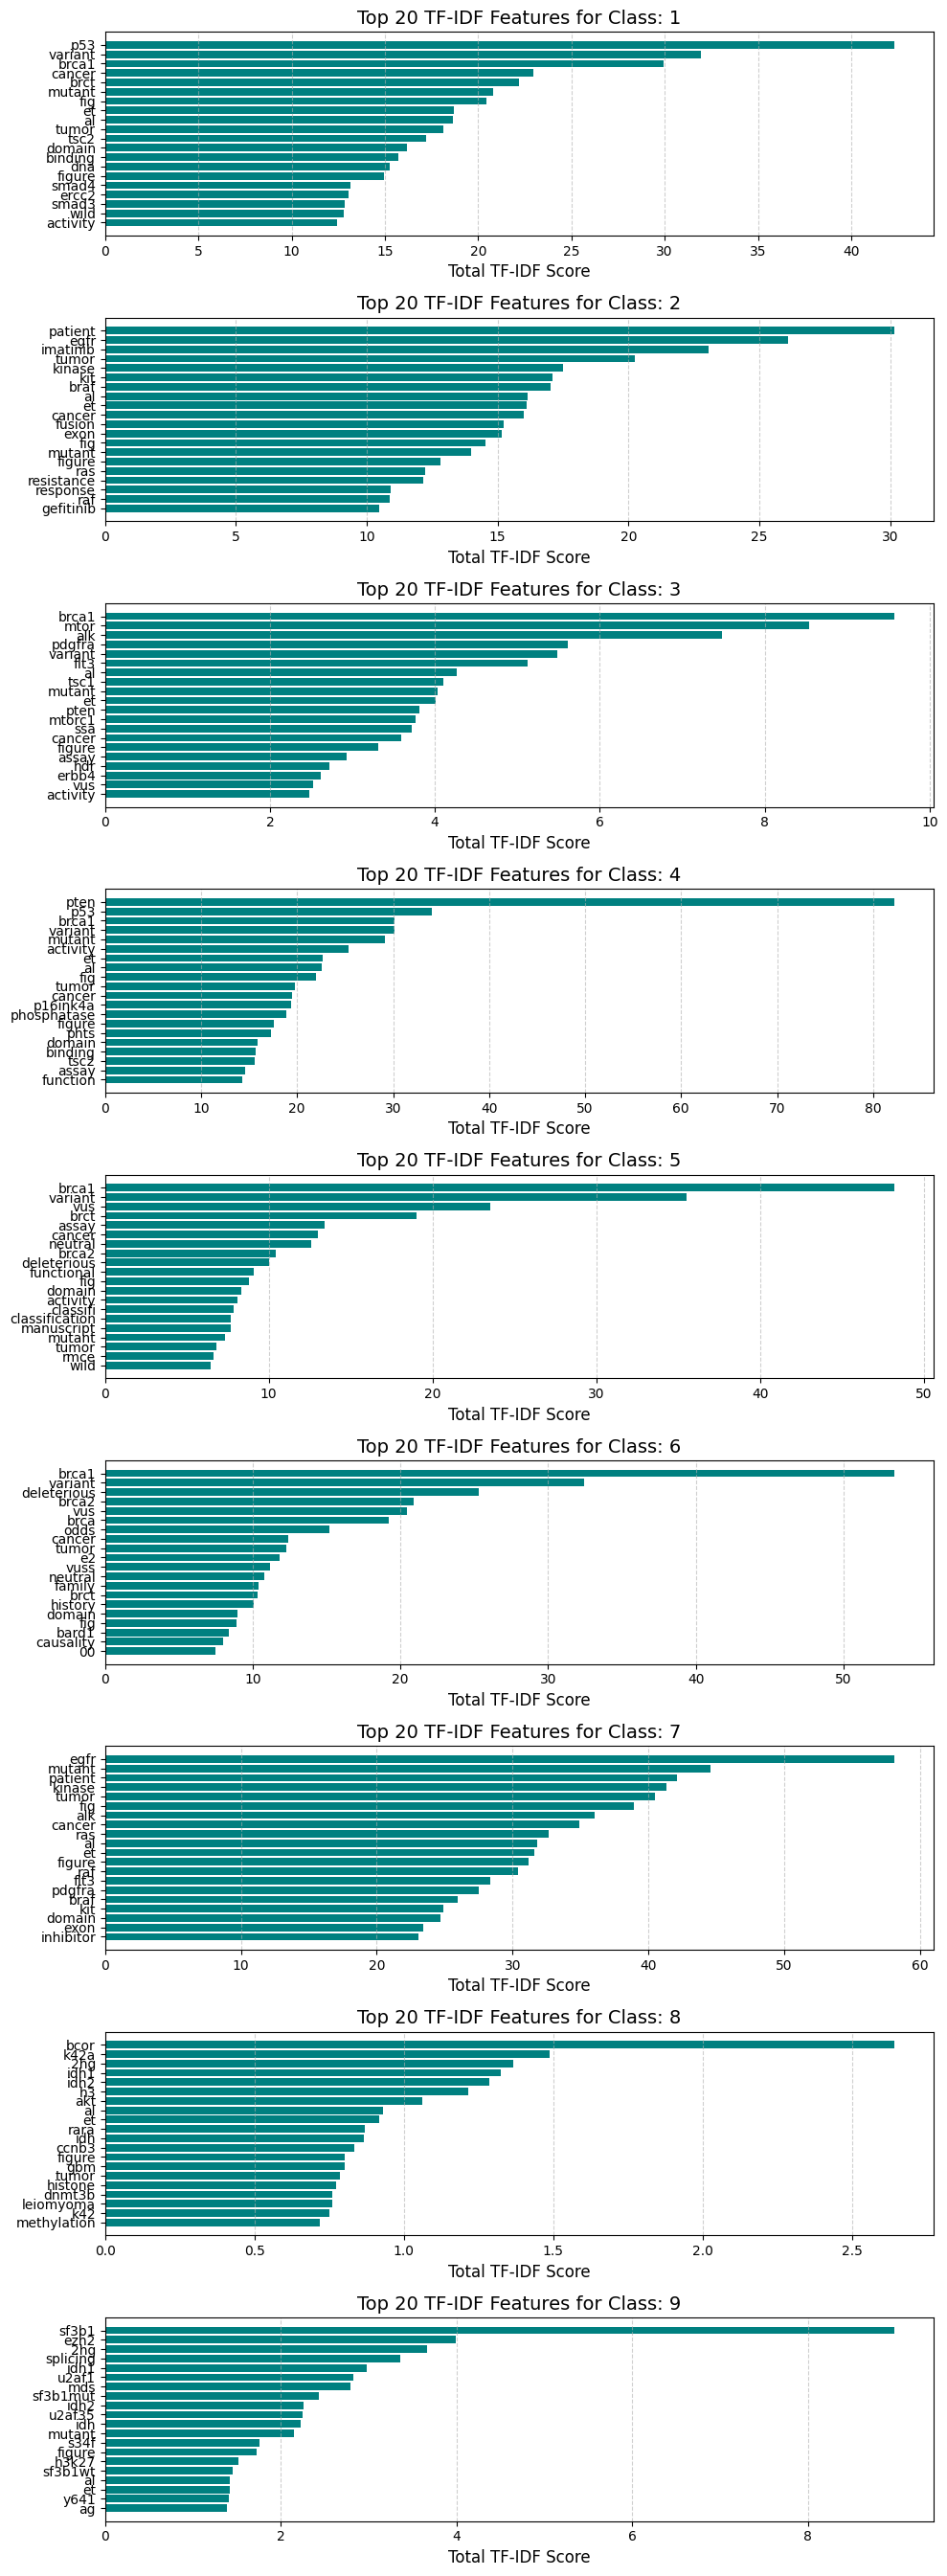

In [13]:
plot_top_tfidf_features_by_class(
    tfidf_training, 
    tfidf, 
    training_subset['Class'].values,
    n_top=20
)

### Top 25 Most Important Words
This simple plot aggregates all words and shows the most occuring ones. Just like in the previous analysis, the most common are also present in all classes, such as `variant`, `mutant`, `cancer` and `tumor`. It's worth noting that the per-class top 20 occurence plot shows more unique words to their class.

Generating Bar Chart for Top 25 TF-IDF Words...


C:\Users\diegomarquezp\AppData\Local\Temp\ipykernel_2596\1244085638.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf_score', y='word', data=df_tfidf, palette='viridis')


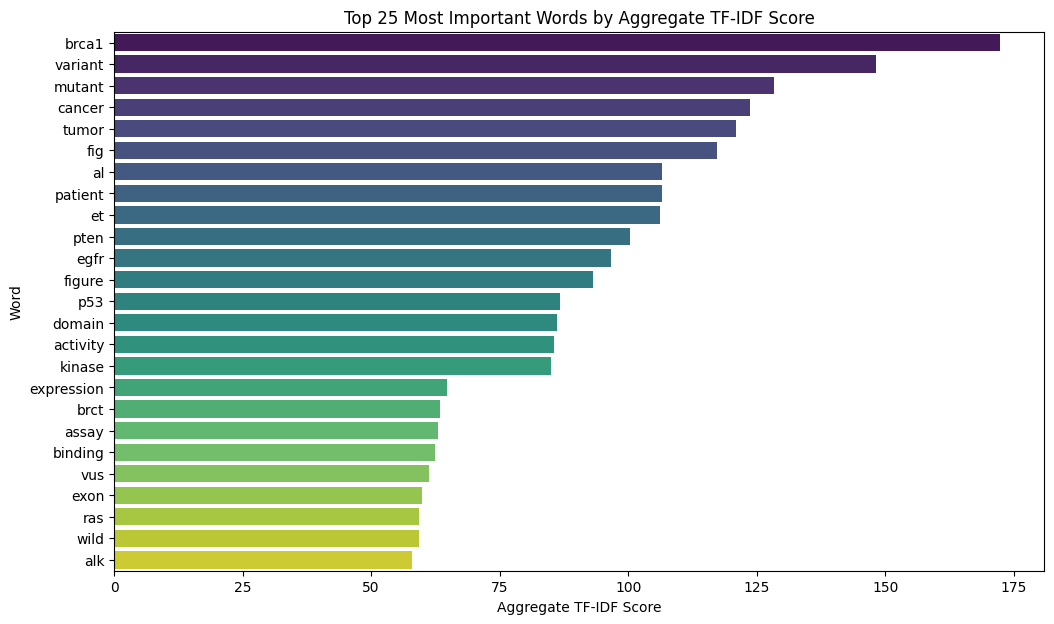

In [14]:
plot_top_tfidf_words(tfidf_training, tfidf, n=25)

### Document length distribution
Here we observe the differences in length of the `Text` entries. We can get up to 50000 tokens in a single entry. 
It's possible that truncating the text to, say, 20k words may have little impact on the prediction accuracy.

Generating Histogram for Document Length Distribution...


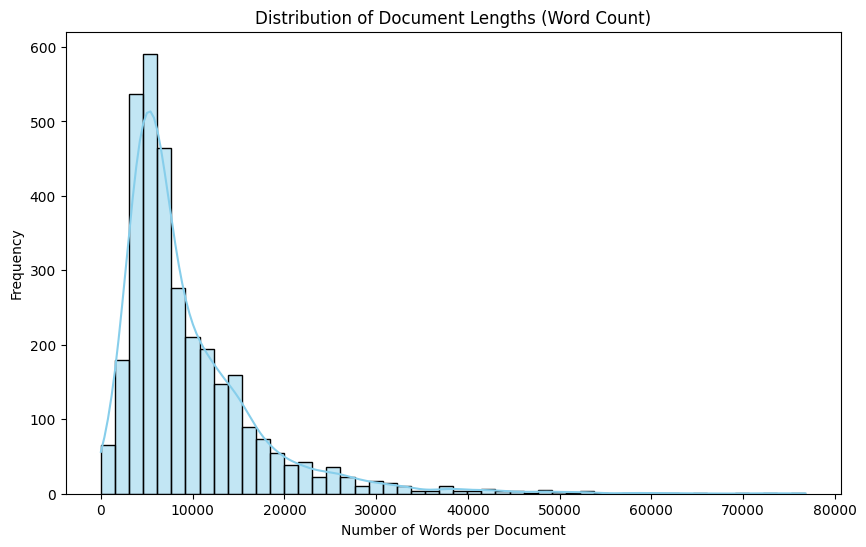

In [15]:
plot_document_length_distribution(training_subset, text_column='Text')

### t-SNE 2d plot
This is an advanced unsupervised learning algorithm. It essentially:
 - calculates the similarity (e.g. ward, euclidean) between every pair of points in the high-dimensional space.
 - the similarities are converted into probabilities defining the likelihood that one point will pick another as its neighbor (Gaussian distribution).
 - tt creates a low-dimensional map (2D or 3D) and calculates new, corresponding similarity probabilities

Although not part of class, it is a promising algorithm that may give more clarity for both our model and visualization, as shown below.
The figure does show some clustering patterns, but they are not entirely obvious.

Generating t-SNE Scatter Plot (Perplexity=30)...
Input matrix has 3 columns. Generating 1 sequential 3D plots.


C:\Users\diegomarquezp\AppData\Local\Temp\ipykernel_2596\1244085638.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


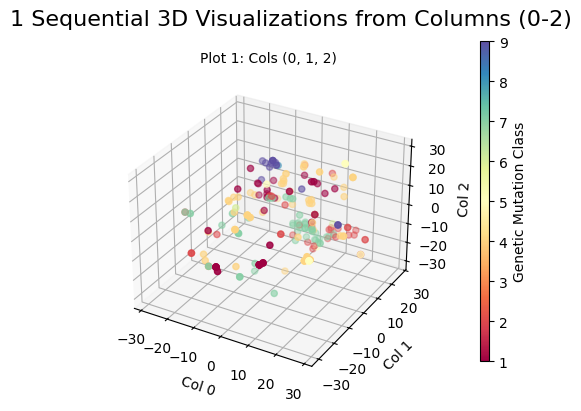

In [16]:
plot_tsne_embeddings(vectorized_training, training_subset, target_column='Class')

### Class distribution
We can see the classes are not evenly distributed.
This can usually be addressed by oversampling the minority class or undersampling the majority class.

Generating Bar Chart for Class Distribution in 'Class'...


C:\Users\diegomarquezp\AppData\Local\Temp\ipykernel_2596\1244085638.py:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='RdBu')


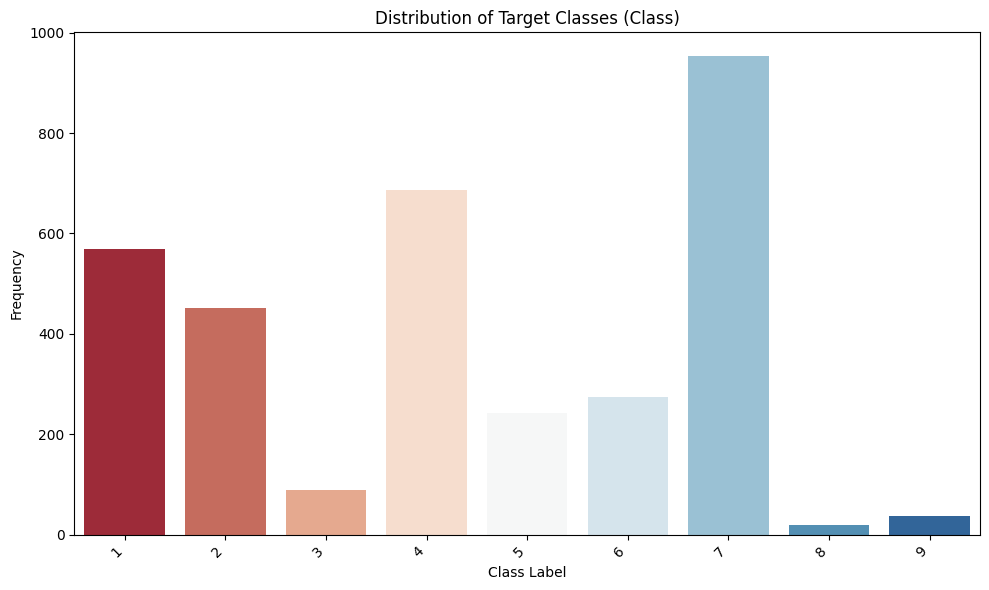

In [17]:
plot_class_distribution(training_subset, target_column='Class') # Change 'Class' if needed

### Principal Component Analysis
Here is a plot of the first 18 components shown as 3d graphs.
We can see there is no significant clustering. In the next section I'll show an algorithm not taught in class but with enough cluster spread to observe differences.

In [18]:
pca = PCA(n_components=20)
training_pca = pca.fit_transform(training_matrix)

Input matrix has 18 columns. Generating 16 sequential 3D plots.


C:\Users\diegomarquezp\AppData\Local\Temp\ipykernel_2596\1244085638.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


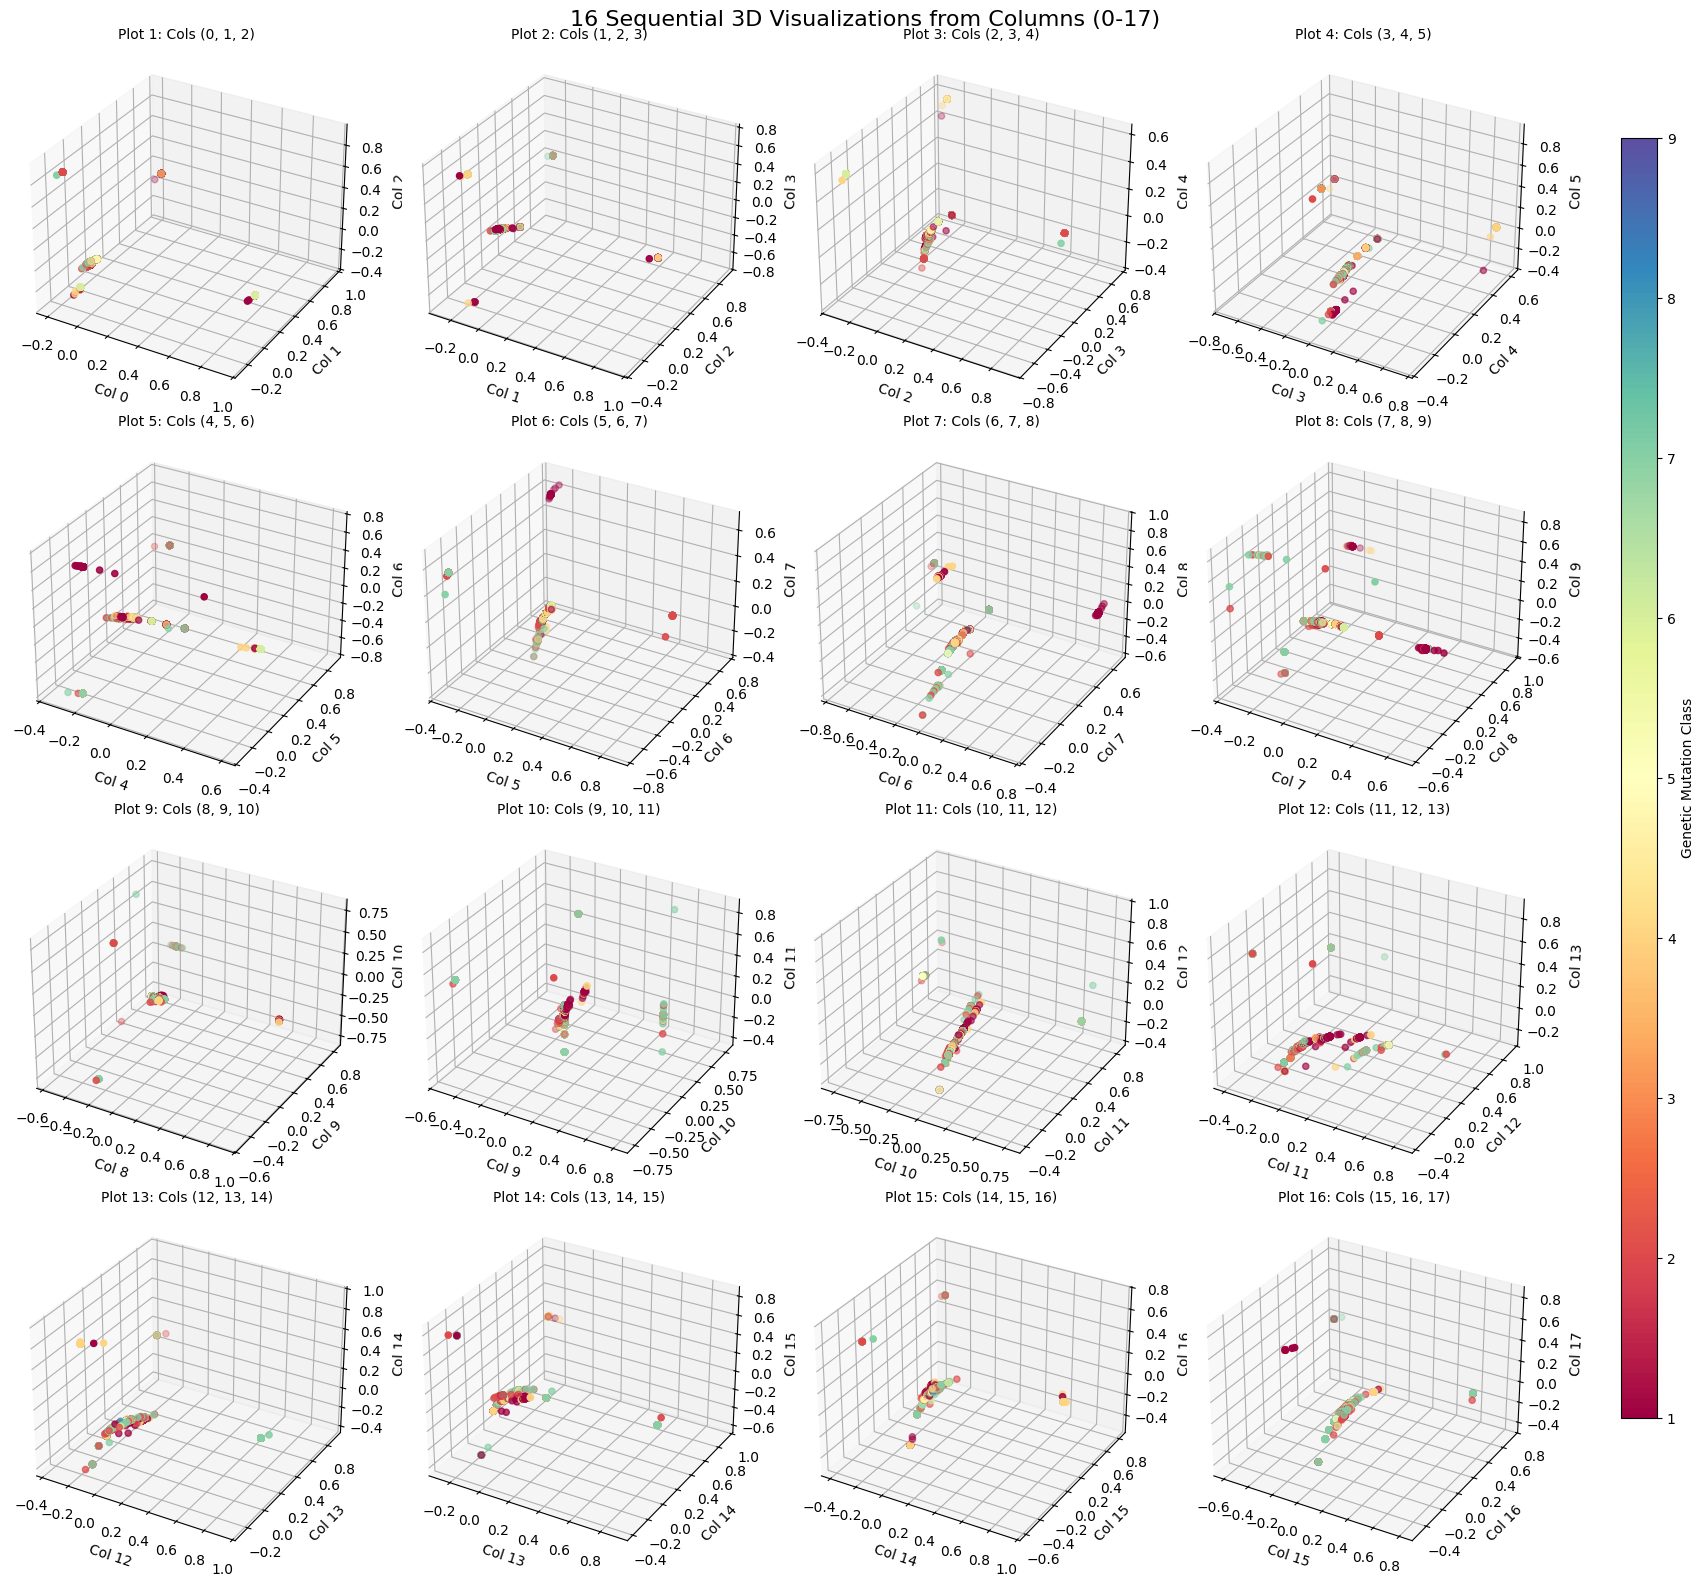

In [19]:
draw_sequential_3d_subplots(training_pca[:,:18], training_subset['Class'])

#### PCA Pairplot
Here we can see that some classes display distinctive features across 2 dimensional plots. This should be enough for a classifier to detect.

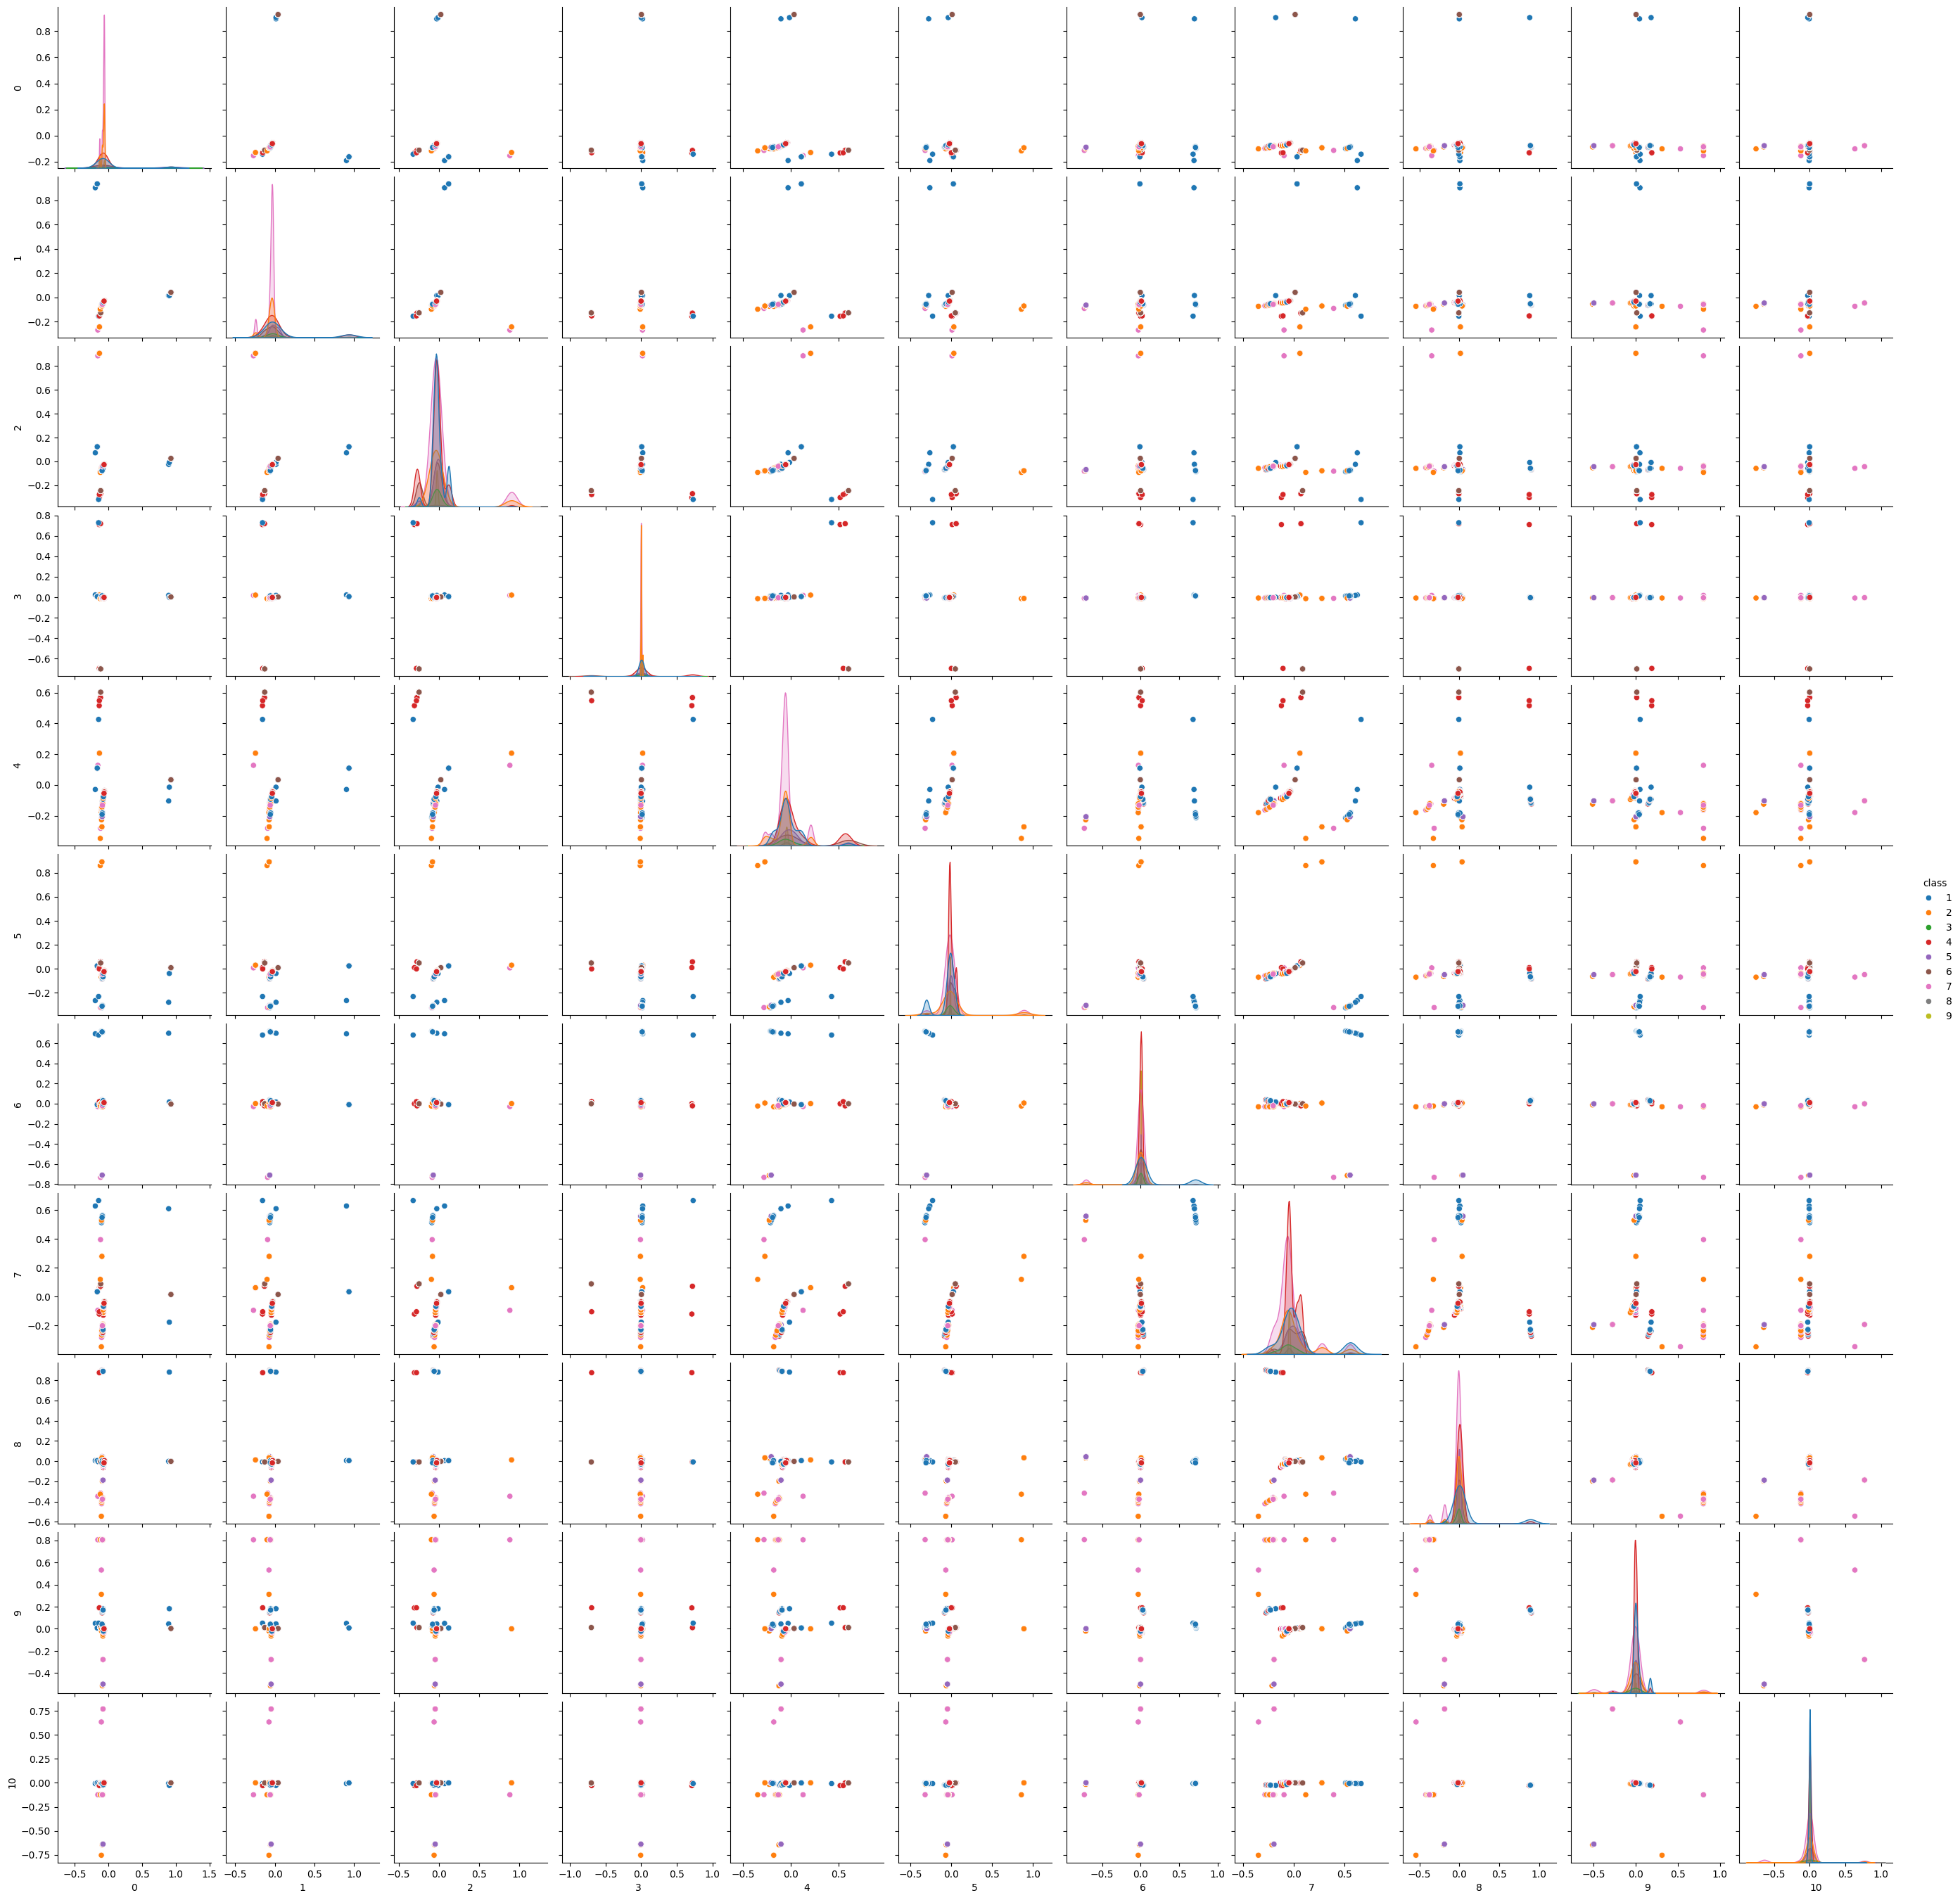

In [20]:
training_pca_df = pd.DataFrame(training_pca[:,0:11])
training_pca_df['class'] = training_subset['Class']
sns.pairplot(pd.DataFrame(training_pca_df), hue='class', palette='tab10');

### Alternative component analysis: UMAP
This unsupervised algorithm, which stands for "Uniform Manifold Approximation and Projection", uses a graph technique where the node links are the probability of likelyhood. This is then projected into an arbitrary number of dimensions. In my case I chose 100 dimensions because I wanted to observe the effectiveness when paired with a classifier.

In [21]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap
umap_pca = umap.UMAP(n_components=100)
training_umap = umap_pca.fit_transform(training_matrix)

Input matrix has 18 columns. Generating 16 sequential 3D plots.


C:\Users\diegomarquezp\AppData\Local\Temp\ipykernel_2596\1244085638.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


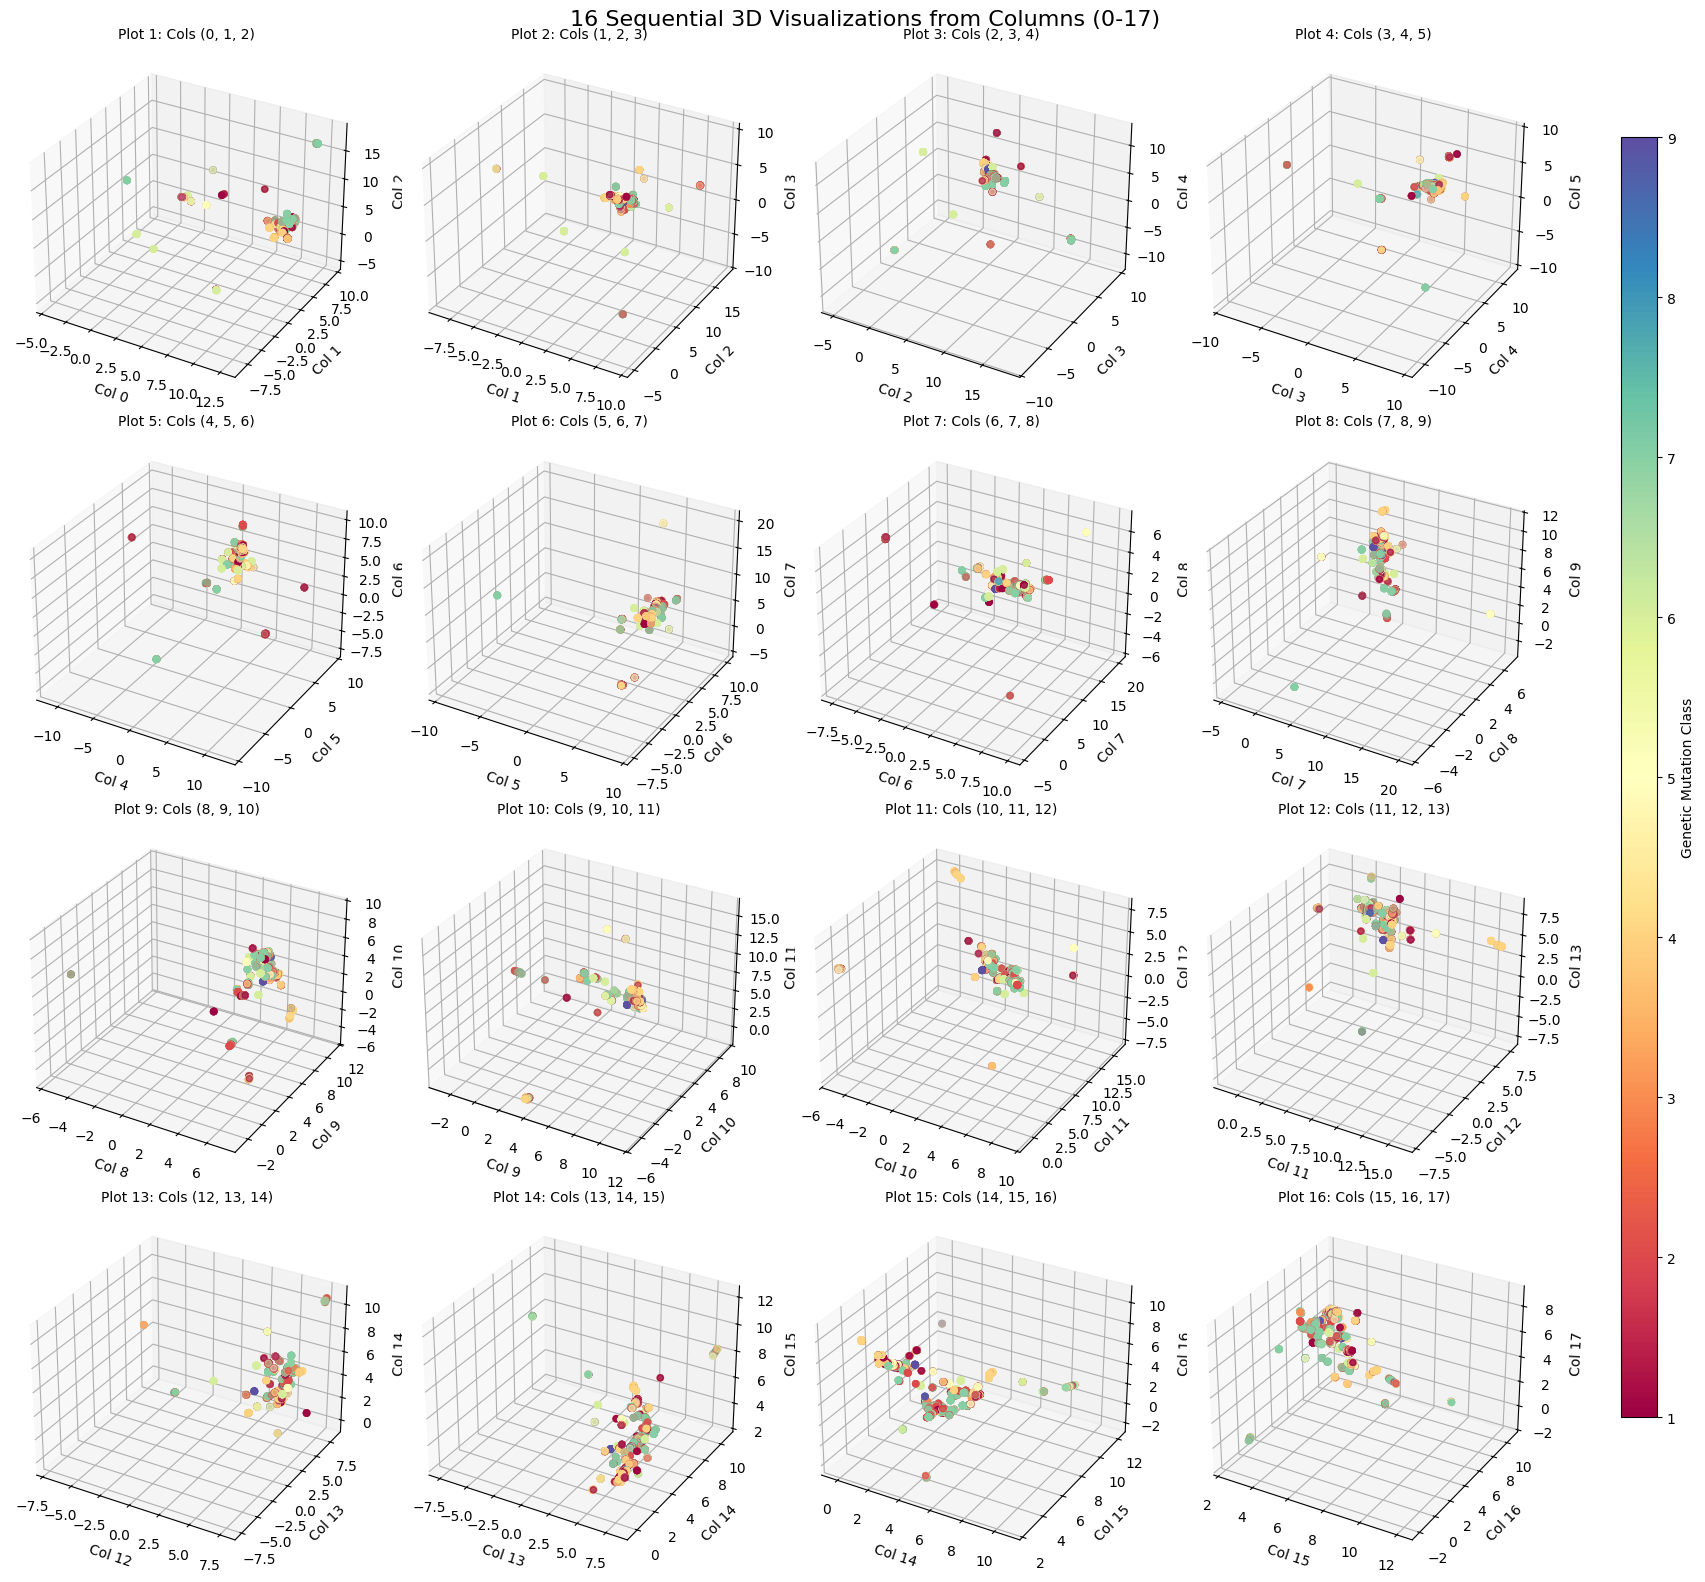

In [22]:
draw_sequential_3d_subplots(training_umap[:,:18], training_subset['Class'])

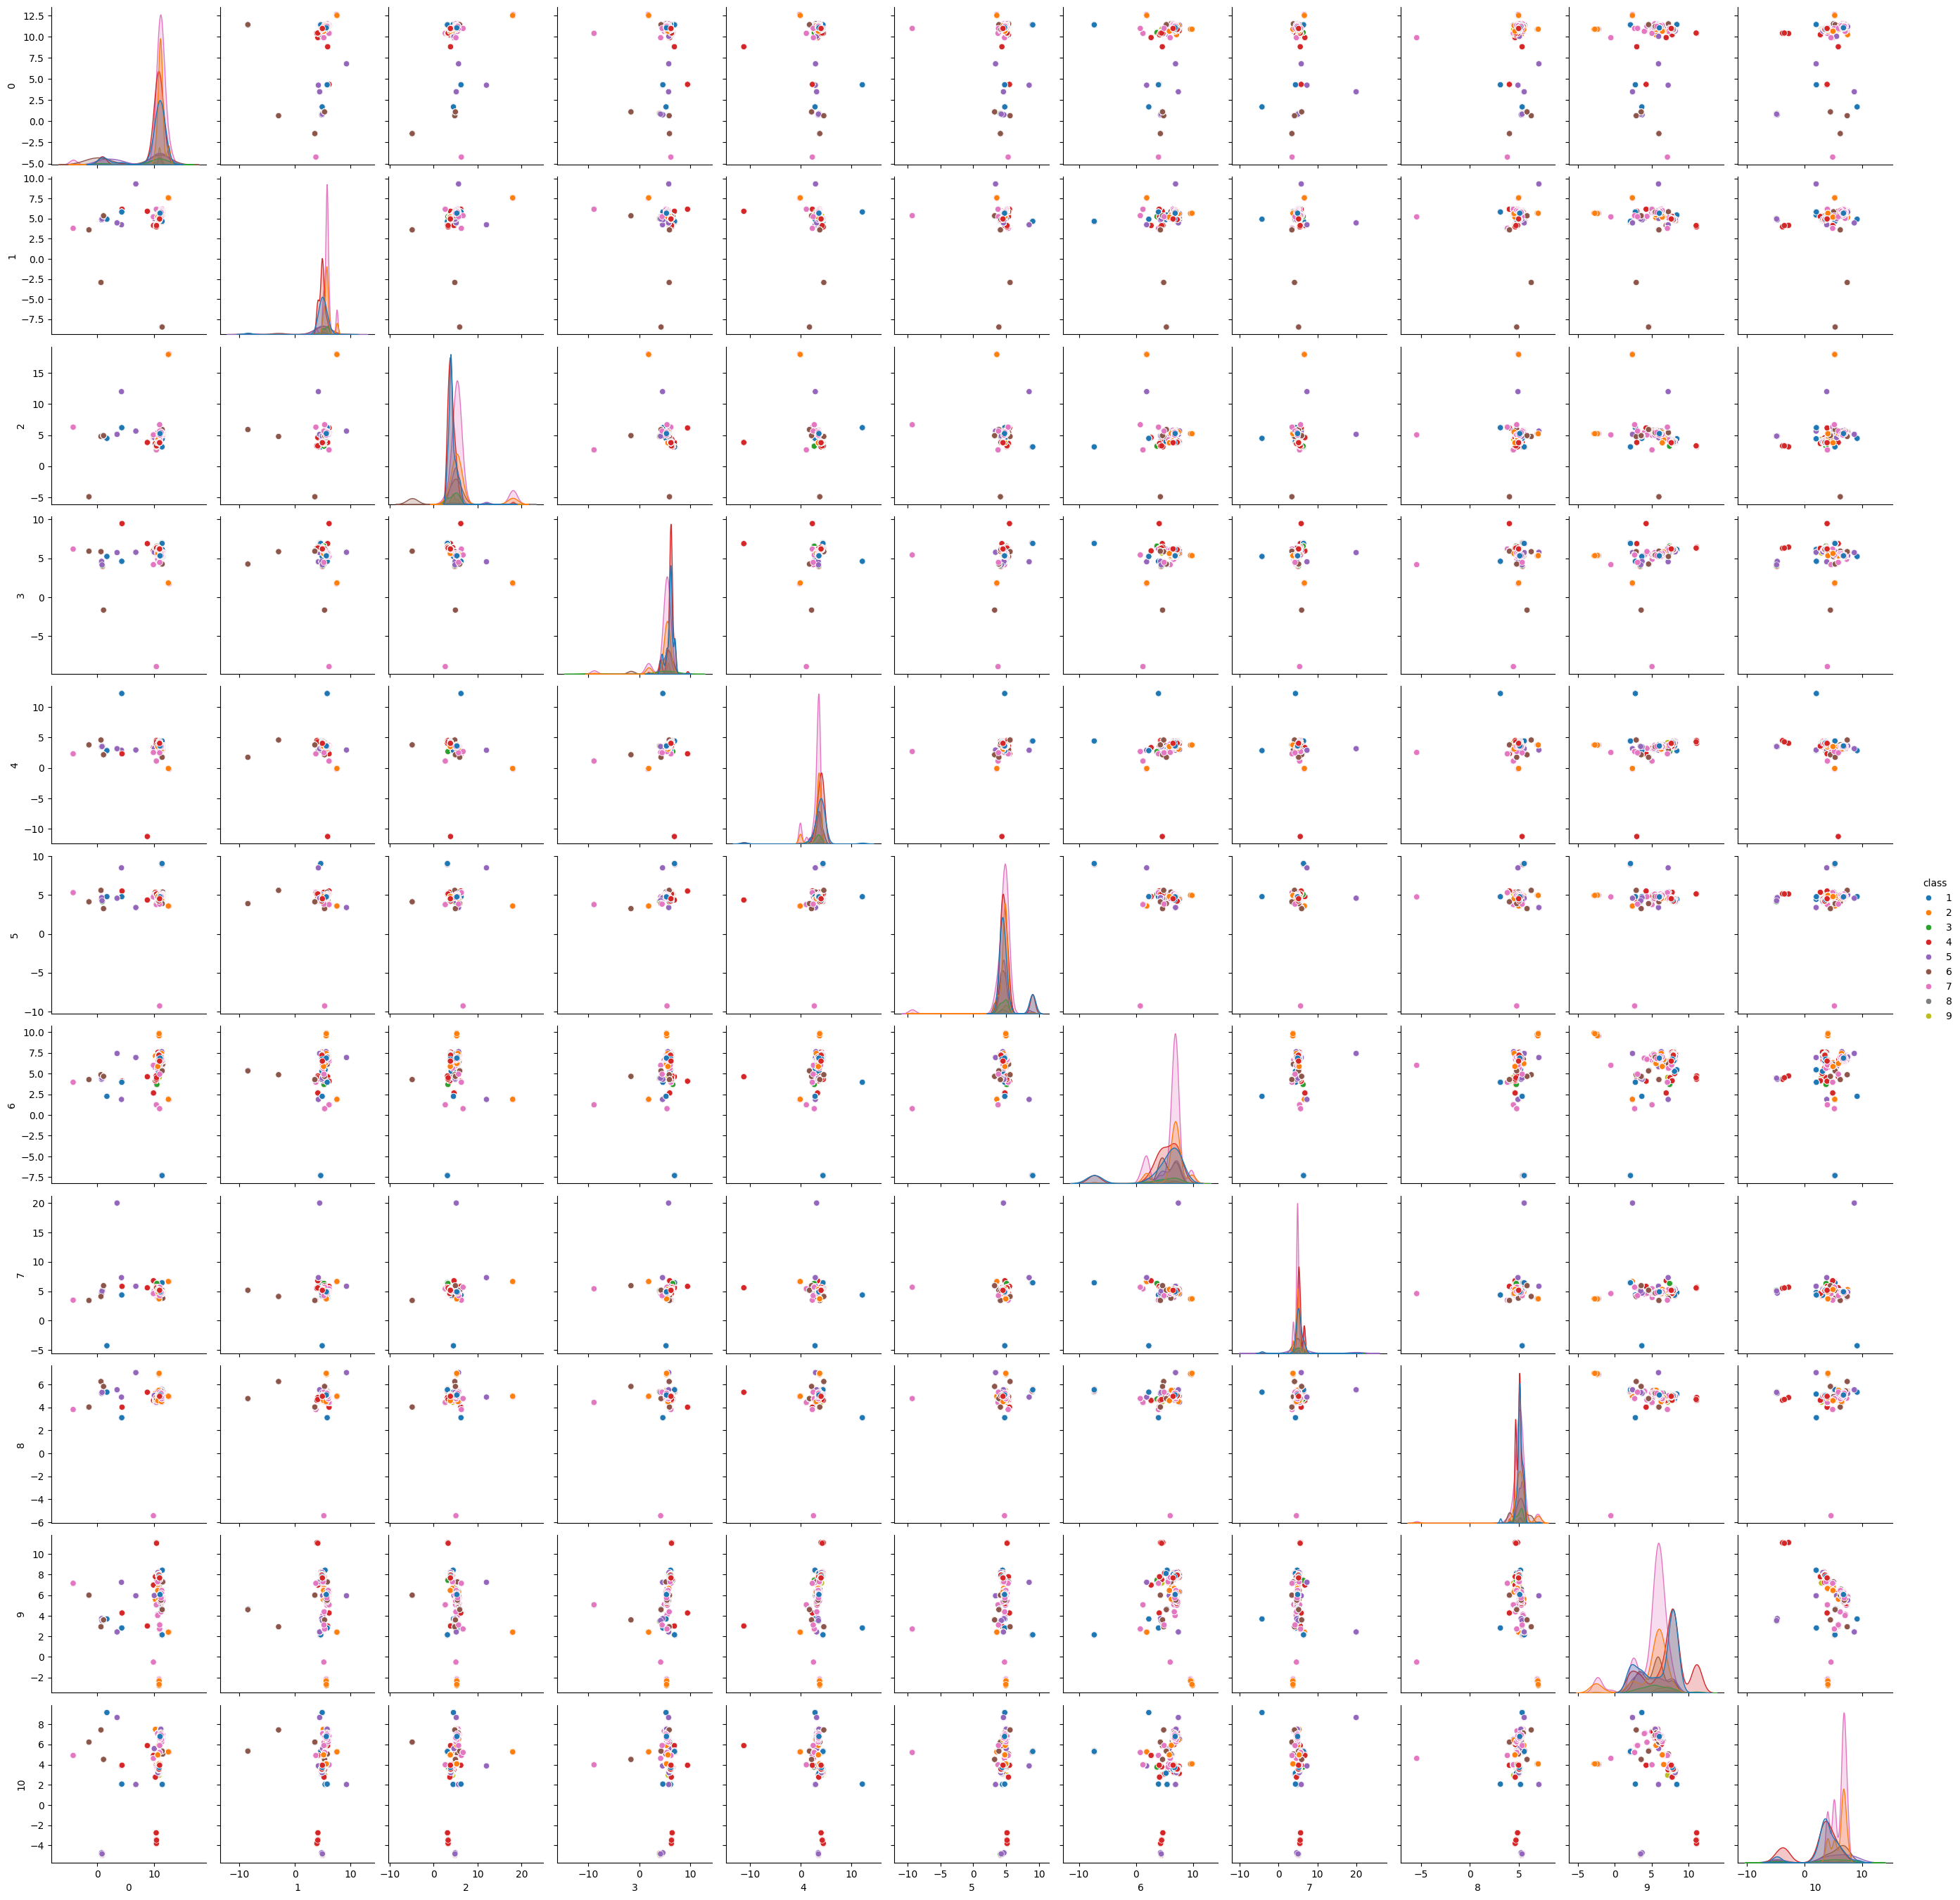

In [23]:
training_umap_df = pd.DataFrame(training_umap[:,0:11])
training_umap_df['class'] = training_subset['Class']
sns.pairplot(pd.DataFrame(training_umap_df), hue='class', palette='tab10');

## Building the Model
Here I will show a few approaches on how to build the best estimator for y value.

### Using K-Means
This unfortunately have an approximate 25% accuracy since we did not input the labels to the training set.
This led me to try Agglomerative Clustering as an alternative method for building clusters, hoping we can match the classes, but the entries were not easily distinguishable.

#### The rand score
This is a score that measures how good our cluster guess was compared to the true y values. 0 means complete random guess and a value of 1 or -1 represents an accurate guess.
As we can see, clustering on our training matrix did not yield any better results than random guessing.

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from itertools import permutations
from sklearn.metrics import adjusted_rand_score
kmeans = KMeans(n_clusters=9)
y_pred = kmeans.fit_predict(training_matrix)
y_true = training_subset['Class'].to_list()
adjusted_rand_score(y_true, y_pred)

0.06622185775797984

### Agglomerative Clustering
Our second attempt at clustering the dataset yielded a similar 4% rand score, meaning there is no obvious similarity between the classes, if the classes are not provided.

In [25]:
from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=9)
y_pred = agglo.fit_predict(training_matrix.toarray())
adjusted_rand_score(y_true, y_pred)

0.05043315177290911

## Another approach for classification: Using a supervised classifier with a lower dimensional dataset
This is similar to our Module 4 assignment, where we reduced the dimensions of our huge matrix into something a simpler classifier can make good predictions of.
In this case I wanted to try both the suggested "single value decomposition", taught in class, which shows very good results when paired with a Random Forest Classifier.

While studying this project, earlier in EDA I came up with t-NSE, which made me curious on how accurate it could be when paired with a supervised classifier.

### The approach: GridSearchCV over several classifiers
_Note_: Gradient boosting yielded 60% but I skipped the execution due to slowness per grid entry

After reducing dimensions with SVD, I used a grid search to find the best model, based only on accuracy.

In [26]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=50)
training_tsvd = tsvd.fit_transform(training_matrix)

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

datasets = {
    'training_tsvd': training_tsvd,
    # 'training_umap': training_umap,
    # 'training_matrix': training_matrix,
    # 'training_pca': training_pca
}

classifiers = {
    'logistic_regression': LogisticRegression,
    'random_forest': RandomForestClassifier,
    # 'gradient_boosting': GradientBoostingClassifier,
    'knn': KNeighborsClassifier,
    'svm': SVC,
}

param_grids = {
    'logistic_regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l2'],
        'max_iter': [1000]
    },
    'random_forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'knn': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2] # 1 is Manhattan distance, 2 is Euclidean distance
    },
    'gradient_boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

results = []
best_acc = 0
best = None

for dataset in datasets.keys():
    for classifier in classifiers.keys():
        X_train, X_test, y_train, y_test = train_test_split(datasets[dataset], training_subset['Class'].to_numpy(), test_size=0.33, random_state=42)
        model = GridSearchCV(classifiers[classifier](), param_grid=param_grids[classifier])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append([classifier, dataset, acc, model, y_pred]) 
        if acc > best_acc:
            best_acc = acc
            best = [classifier, dataset, acc, model, y_pred]
        print(f'{classifier} on {dataset} dataset: {acc}')
        

logistic_regression on training_tsvd dataset: 0.5593065693430657
random_forest on training_tsvd dataset: 0.6697080291970803
knn on training_tsvd dataset: 0.656934306569343
svm on training_tsvd dataset: 0.5611313868613139


In [28]:
def plot_accuracy_comparison(results_list):
    """
    Generates a bar chart to compare the accuracy scores from the GridSearchCV results.

    Args:
        results_list (list of lists): The 'results' list from the user's pipeline,
                                      structured as [classifier, dataset, acc, model, y_pred].
    """
    # Create DataFrame from the results list
    df_scores = pd.DataFrame(results_list, columns=['Classifier', 'Dataset', 'Accuracy Score', 'Model', 'y_pred'])

    # Create a combined label for better comparison (Classifier on Dataset)
    df_scores['Model_Label'] = df_scores['Classifier'].str.replace('_', ' ').str.title() + ' on ' + df_scores['Dataset'].str.upper()

    # Sort by score for better visualization
    df_scores = df_scores.sort_values(by='Accuracy Score', ascending=False)

    plt.figure(figsize=(12, 7))

    # Use seaborn for a clear bar plot
    ax = sns.barplot(
        x='Accuracy Score',
        y='Model_Label',
        data=df_scores,
        palette='magma'
    )

    # Add labels on the bars
    for p in ax.patches:
        ax.annotate(
            f'{p.get_width():.4f}',
            (p.get_width(), p.get_y() + p.get_height() / 2.),
            ha='left', va='center',
            fontsize=11, color='black',
            xytext=(5, 0),
            textcoords='offset points'
        )

    plt.title('Comparison of Model Accuracy Scores Across Different Feature Sets')
    plt.xlim(df_scores['Accuracy Score'].min() * 0.9, 1.0) 
    plt.xlabel('Accuracy Score')
    plt.ylabel('Model and Feature Set')
    plt.tight_layout()
    plt.show()

C:\Users\diegomarquezp\AppData\Local\Temp\ipykernel_2596\1900903524.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


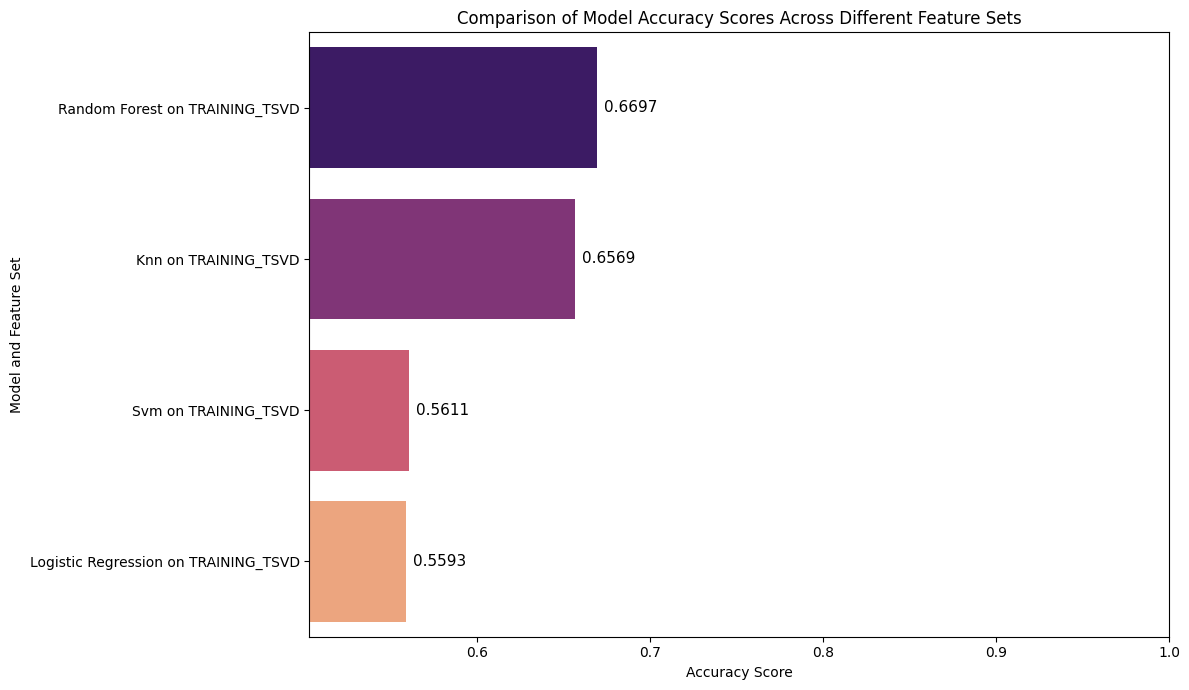

In [29]:
plot_accuracy_comparison(results)

In [34]:
classifier, dataset, acc, model, y_pred = best
print(model.get_params())

{'cv': None, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(), 'n_jobs': None, 'param_grid': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


## The Best Model: RandomForestClassifier
The Random Forest Classifer proved best when using any of the reduced-dimension datasets.
However, the accuracy was only up to about ~70%, which definitely outlines some room for improvement. I'll generate a few hypotheses in the section after the result analysis.

### Confusion Matrix

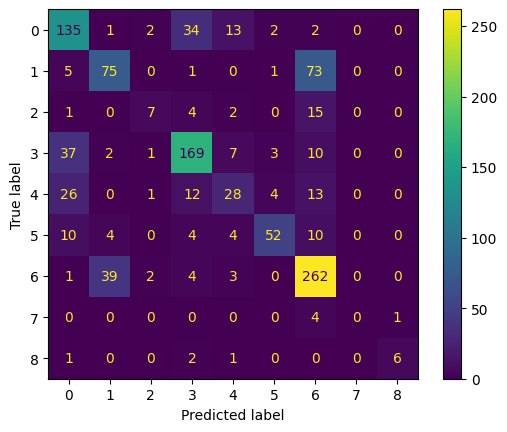

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classifier, dataset, acc, model, y_pred = best
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

## Conclusion: 68% Accuracy on a vectorized text dataset
I think the dimensionality reduction combined with a classifier definitely yielded decent results. However, I strongly suspect the problem went on the side of vectorizing the text dataset.

One thing I found was worth a follow up: **3000 entries for Word2Vec is considered "not enough" for having impactful word vectors** (Gemini, 2025). Usually, for these applications it's recommended to use a trained vector database, but I considered out of the scope of a university project to use a pre-trained dataset because this work is meant to produce our own data relationships.

Another limitation I had was that the sparse matrix produced by TF-IDF would go over 1 million columns if using `min_df=1`, meaining that there were way too many different words, which was **likely to have a strong impact on the outcome of word2vec**.

Lastly, this dataset required dense knowledge of NLP techniques, which were not very much on the scope of this project, so it was definitely a weak spot for this study.

But nevertheless: the technique of reducing dimensions and combining with a supervised classifier was definitely a positive learning outcome of this course which led to 70% accuracy in a ML field not yet taught in our course.

Thank you for taking the time to read this study!